### This file decribes how to get scrape a working csv-file from wikinews.org

# IT NEED A LOT OF STUFF NOT IMPLEMENTED COMPLITELY

Table taken from: https://github.com/several27/FakeNewsCorpus - go there for better table formating

| Type | Tag | Count (so far) | Description|
| ------------- |-------------|:-------------:|:-------------:|
| **Fake News** | fake | 928,083 | Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports |
| **Satire** | satire | 146,080 | Sources that use humor, irony, exaggeration, ridicule, and false information to comment on current events. |
| **Extreme Bias** | bias | 1,300,444 | Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts. |
| **Conspiracy Theory** | conspiracy | 905,981 | Sources that are well-known promoters of kooky conspiracy theories. |
| **State News** | state | 0 | Sources in repressive states operating under government sanction. |
| **Junk Science** | junksci | 144,939 | Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims. |
| **Hate News** | hate | 117,374 | Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination. |
| **Clickbait** | clickbait | 292,201 | Sources that provide generally credible content, but use exaggerated, misleading, or questionable headlines, social media descriptions, and/or images. |
| **Proceed With Caution** | unreliable | 319,830 | Sources that may be reliable but whose contents require further verification. |
| **Political** | political | 2,435,471 | Sources that provide generally verifiable information in support of certain points of view or political orientations. |
| **Credible** | reliable | 1,920,139 | Sources that circulate news and information in a manner consistent with traditional and ethical practices in journalism (Remember: even credible sources sometimes rely on clickbait-style headlines or occasionally make mistakes. No news organization is perfect, which is why a healthy news diet consists of multiple sources of information). |

In [1]:
# Follow the link below:
# https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
# https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/



import psycopg2
import nltk
import pandas as pd
import numpy as np
import re
import string

### Import and get basic information about the data

First we import the data and get an idea about how it it structured and so on such that we can better understand what has to be done.

- Below we import and create a type_id colum (might remove later)


In [2]:
# importing and creating df (has to have type_id)

# usage: specify file location, sample size and seed(used by random) 
filepath = '../Data_sample/FakeNewsCorpus_250.csv' # 250 rows of FakeNewsCorpus
s = 250                                            # desired sample size
seed = 1                                           # seed used by Pseudorandom number generator

df = pd.read_csv(filepath, index_col = [0]).sample(n=s, random_state=seed)
df["content"] = df["content"].astype(str)
# create type_id
df['type_id'] = df.groupby(['type']).ngroup()

df.head()

,Unnamed: 0.1,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,content_tokens,type_id
67,67,11593,washingtonexaminer.com,political,http://www.washingtonexaminer.com/us-support-f...,The United States has slashed its contribution...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,US support for UNRWA has gone on long enough,Michael Rubin,NaN,"['Blog Contributors', 'Refugees', 'Palestinian...","When the U.N. created UNRWA, it was meant to b...",NaN,NaN,[],6
249,249,39558,www.newsmax.com,NaN,https://www.newsmax.com/newsfront/bill-clinton...,Former U.S. President Bill Clinton on Monday c...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Bill Clinton Calls for Release of Reuters Jour...,NaN,NaN,"['bill clinton', 'myanmar', 'calls', 'release'...",Former U.S. President Bill Clinton Calls for R...,"Donald Trump, Russia, Trump Administration, Gu...",NaN,[],-1
230,230,37351,beforeitsnews.com,fake,http://beforeitsnews.com/alternative/2018/01/t...,The Real Story Behind Marijuana Prohibition\n\...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,The Real Story Behind Marijuana Prohibition,The Daily Sheeple,NaN,[''],NaN,NaN,NaN,[],3
161,161,25191,beforeitsnews.com,fake,http://beforeitsnews.com/health/2017/04/audio-...,Audio Sensors Market Analysis by Current Indus...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Audio Sensors Market Analysis by Current Indus...,NaN,NaN,[''],NaN,NaN,NaN,[],3
91,91,15468,beforeitsnews.com,fake,http://beforeitsnews.com/science-and-technolog...,Headline: Bitcoin & Blockchain Searches Exceed...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Yawning — Why Is It So Contagious and Why Shou...,Alton Parrish,NaN,[''],NaN,NaN,NaN,[],3


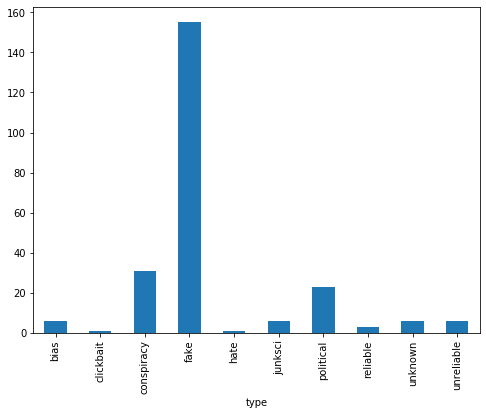

In [3]:
# plotting of categories

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('type').content.count().plot.bar(ylim=0)
plt.show()

,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,meta_keywords,meta_description,tags,content_tokens
count,250,238,250,250,250,250,250,250,170,250,54,27,250
unique,29,10,250,239,2,1,1,248,109,36,51,24,1
missing,0,12,0,0,0,0,0,0,80,0,196,223,0


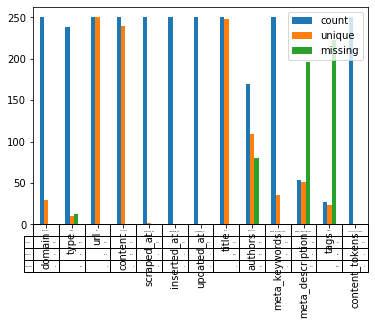

In [4]:
# Calculating number: count, unique for each column
describe_df = df.describe(include=[np.object]).head(2)

# Calculating number: NaN for each column
nan_df = df.isna().sum()

# Create one df
describe_df.loc['missing'] = nan_df
# plot
describe_df.T.plot(kind='bar',  table=True)
describe_df # just display numbers

### Dataset Preparation

Here we start the cleaning process. There are a lot of steps and the code can be a little complicated. Some steps have to be before others as they overrule the previous 

- how to implement is still up for debate as it can be smart to use small cells for each step or get all in one big cleaning step but display when they are done
- **READ** all excersice 1-7 on KU

### Common data cleaning steps
- make text all lower case
- remove puntuiation
- remove numerical values
- remove common non-sensial text(/n)
- tokanize text

### # steps that need to be included
- -NUM -DATE -EMAIL -URL
- replace nan with 'NULL'

### Text blob cleaning
The first cleaning-step is wokring on text blobs ie. all text at the same time

In [67]:
# working with content as a series
series_content = df['content']

### DEBUG SETUP - COMPARE CLEAN VS NON_CLEAN ###
sample_num = 3
before = series_content.iloc[sample_num]
### DEBUG SETUP - COMPARE CLEAN VS NON_CLEAN ###

### Order matters - (not final order of pipeline)
### Overall preprocessing

# lower_cast - NEEDED? - DONE by many libs
%time print("\n (lower_cast)"); series_content = series_content.str.lower()

### replace [name] with tokens in text ###

# Email_replace
regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
%time print("\n (Email_replace)"); series_content = series_content.replace(to_replace=regexEmail, value=' <EMAIL> ', regex=True)

# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
%time print("\n (URL_replace)"); series_content = series_content.replace(to_replace=regexURL, value=' <URL> ', regex=True)

# HTML_replace
regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
%time print("\n (HTML_replace)"); series_content = series_content.replace(to_replace=regexHTML, value=' <HTML> ', regex=True)

# Date_replace - NOT DONE
# - name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
# - day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
# - year         ([12][0-9]{3})         - Years from 1000 to 2999
regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
%time print("\n (Date_replace)"); series_content = series_content.replace(to_replace=regexDate, value=' <DATE> ', regex=True)

# Number_replace
regexNum = r"[0-9][0-9,\.]+" # nums with [0-9] and [,.]
series_content = series_content.replace(to_replace=regexNum, value=' <NUM> ', regex=True)

### string removal functions ###
# New_line_remove
regexNEWLINE = r"\n|\\n"
%time print("\n (New_line_remove)"); series_content = series_content.replace(to_replace=regexNEWLINE, value=' ', regex=True)

# Punctuation_remove
regexPunkt = r"[!“”\"#$%&()*+,\-–.…\/:;<=>?@[\\\]^_`{|}~'\’\']" # also removes: " ' " which means ie. it's -> its - remove \' from regwex if not needed
%time print("\n (Punctuation_remove)"); series_content = series_content.replace(to_replace=regexPunkt, value='', regex=True)

# Non_ASCII_remove - Maybe a step too much
%time print("\n", series_content = series_content.str.encode('ascii', 'ignore').str.decode('ascii')

# After all steps
print("\n (Done cleaning)")

### DEBUG PRINT - COMPARE CLEAN VS NON_CLEAN ###
print("[before]\n", repr(before), "\n\n[After]\n", repr(series_content.iloc[sample_num]) )
### DEBUG PRINT - COMPARE CLEAN VS NON_CLEAN ###


 (lower_cast)
CPU times: user 4.87 ms, sys: 43 µs, total: 4.91 ms
Wall time: 4.81 ms

 (Email_replace)
CPU times: user 40.1 ms, sys: 0 ns, total: 40.1 ms
Wall time: 39.2 ms

 (URL_replace)
CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 125 ms

 (HTML_replace)
CPU times: user 1.55 ms, sys: 0 ns, total: 1.55 ms
Wall time: 1.38 ms

 (Date_replace)
CPU times: user 246 ms, sys: 0 ns, total: 246 ms
Wall time: 246 ms

 (New_line_remove)
CPU times: user 9.77 ms, sys: 0 ns, total: 9.77 ms
Wall time: 9.65 ms

 (Punctuation_remove)
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.6 ms

 (Non_ASCII_remove)
CPU times: user 3.16 ms, sys: 0 ns, total: 3.16 ms
Wall time: 3.12 ms

 (Done cleaning)
[before]
 'Audio Sensors Market Analysis by Current Industry Status & Growth Opportunities, Top Key Players, Target Audience and Forecast to 2022\n\n% of readers think this story is Fact. Add your two cents.\n\nHeadline: Bitcoin & Blockchain Searches Exceed Trump! Blockchain Stoc

### Tokeniztion for futhere cleaning - slow step?

In [74]:
# tokenization and furthur cleaning

# This step might be much slower and therfore the least work should be done here

# tokenize text
token_list_series = series_content.str.split()



67     [the, united, states, has, slashed, its, contr...
249    [former, us, president, bill, clinton, on, mon...
230    [the, real, story, behind, marijuana, prohibit...
161    [audio, sensors, market, analysis, by, current...
91     [headline, bitcoin, blockchain, searches, exce...
                             ...                        
137    [headline, bitcoin, blockchain, searches, exce...
72     [a, weird, week, draws, to, a, close, headline...
140    [how, to, easily, understand, the, difference,...
235    [error, main, error, mesage, here, more, detai...
37     [greg, hunter, big, banks, in, big, trouble, s...
Name: content, Length: 250, dtype: object

In [100]:
# series_content[series_content['content'].apply(regexDate)]

df1 =series_content.str.extract(r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*").isnull()

In [106]:
df1['mask'] = series_content.str.contains('(\d+[A-Z]+\d+)')


In [113]:
pat = r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
df_bool = series_content.str.contains(pat)

In [117]:
result = pd.DataFrame(series_content.str.extract(r'([\d]+)',expand=False))


In [67]:
from time import perf_counter 
t1_start = perf_counter()  
# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
series_content = series_content.replace(to_replace=regexURL, value='<URL>', regex=True)

# Stop the stopwatch / counter 
t1_stop = perf_counter() 
  
print("Elapsed time:", t1_stop, t1_start)  

Elapsed time: 7556.248846449 7554.760254202


In [70]:
import time
 
class MeasureDuration:
    def __init__(self):
        self.start = None
        self.end = None
 
    def __enter__(self):
        self.start = time.time()
        return self
 
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.time()
        print("Total time taken: %s" % self.duration())
 
    def duration(self):
        return str((self.end - self.start) * 1000) + ' milliseconds'

In [1]:
from time import time

class Timer():
    def __init__(self, message):
        self.message = message
    def __enter__(self):
        self.start = time()
        return None  # could return anything, to be used like this: with Timer("Message") as value:
    def __exit__(self, type, value, traceback):
        elapsed_time = (time() - self.start) * 1000
        print(self.message.format(elapsed_time))

In [46]:
df = pd.DataFrame({'x': [1, 2, 3, 4], 'y': [5, 6, 7, 8]})

# runs on single core
df['x2'] = df['x'].apply(lambda x: x**2)
# runs on multiple cores
df['x2'] = df['x'].swifter.apply(lambda x: x**2)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.content).toarray()
labels = df.type_id
features.shape

(5000, 39001)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['type_id'], df['content'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)clf = MultinomialNB().fit(X_train_tfidf, y_train)

SyntaxError: invalid syntax (<ipython-input-8-8ae1abe34dc4>, line 10)

In [ ]:
def remove_stopwords(text): # words like 'the', 'a', 'me' - SLOW
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# def lower_cast(series_in): # Maybe not needed - lower casing is DONE my most of the modern day vecotirzers and tokenizers
#     """Lower Casing"""
#     return series_in.str.lower()

# def Email_replace(series_in):
#     """Replace emails with token"""
#     regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
#     return series_in.replace(to_replace=regexEmail, value='<EMAIL>', regex=True)

# def HTML_replace(series_in):
#     """REpalce HTML wiith token"""
#     regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
#     return series_in.replace(to_replace=regexHTML, value='<HTML>', regex=True)

# def Date_replace(series_in): # NOT WORKING PROBABLY - needs to be recreated
#     """Replace dates with token"""
#     # name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
#     # day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
#     # year         ([12][0-9]{3})         - Years from 1000 to 2999
#     regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
#     return series_in.replace(to_replace=regexDate, value='<DATE>', regex=True)

# def Number_replace(series_in): 
#     """Replace numbers with token"""
#     regexNum = r"[0-9][0-9,\.]+" # type of nums with [0-9] and [,.]
#     return series_in.replace(to_replace=regexNum, value='<NUM>', regex=True)

# def End_of_line_remove(series_in):
#     """Remove end_of_line \n"""
#     regexNL = r"(\\n)"
#     return series_in.replace(to_replace=regexNL, value=' ', regex=True)

# def Punctuation_remove(series_in): 
#     """Remove punctuations"""
#     regexPunkt = r"[!“”\"#$%&()*+,\-–.\/:;<=>?@[\\\]^_`{|}~'\’\']" # also removes: " ' " which means ie. it's -> its - remove \' from regex if not needed
#     series_in.replace(to_replace=regexPunkt, value='', regex=True)
